# Sybil Detection

In [1]:
import os
import pandas as pd
import numpy as np

from avd.graph_learning_controller import GraphLearningController
from avd.learners.sklearner import SkLearner
from avd.configs import config
from avd.datasets.twitter import load_data

Specify output directory for classifiers.

In [2]:
output_folder = os.getcwd() + "/data/output"
if not os.path.exists(output_folder):
    os.mkdir(output_folder)

Define what is considered positive and negative labels.

In [3]:
labels = {"neg": "Real", "pos": "Fake"}

We first load the Twitter graph.
load_data will return a graph object(twitter_graph) and a config object(twitter_config).

In [4]:
twitter_graph, twitter_config = load_data(dataset_file_name="twitter_filtered.csv", labels_file_name="twitter_labels_filtered.csv", 
                                          labels_map=labels, limit=5000000) # Loads filtered dataset.
print(len(twitter_graph.vertices))

Loading labels...
Loading graph...
Data loaded.
2320975


Some of the extracted feature can be useful for understanding the result, but they will not be used in the classification proccess.

In [5]:
if twitter_graph.is_directed:
    meta_data_cols = ["dst", "src", "out_degree_v", "in_degree_v", "out_degree_u", "in_degree_u"]
else:
    meta_data_cols = ["dst", "src", "number_of_friends_u", "number_of_friends_v"]

Finally, we train the classification algorithm.
The Twitter dataset is incomplete and missing a lot of data.
In order to deal with this problem, we train 10 times and aggregate the results.

In [6]:
#for i in range(10):
twitter_config._name = "twitter_" + "linksProbability_"# + str(i) + "_"
learner = SkLearner(labels=labels)
glc = GraphLearningController(learner, twitter_config)
result_path = os.path.join(output_folder, twitter_config.name  + "res.csv")
glc.classify_by_links(twitter_graph, 
                      result_path, 
                      test_size={"neg": 2000, "pos": 200},
                      train_size={"neg": 5000, "pos": 5000}, 
                      meta_data_cols=meta_data_cols)

Setting training and test sets
Existing files were loaded.


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework

Training 10-fold validation: {'auc': 0.9025091999999999, 'recall': 0.8375999999999999, 'precision': 0.8058469077211381, 'accuracy': 0.8149, 'fpr': 0.20779999999999998, 'tnr': 0.7922}
An error occuurred.
Validate_prediction_by_links: {'auc': 1.0, 'recall': 0.3617021276595745, 'precision': 0.085, 'accuracy': 0.9031818181818182, 'fpr': 0.08499767765908035}


In [7]:
def aggreagate_res(data_folder, res_path):
    results_frame = pd.DataFrame()
    for f in os.listdir(data_folder):
        temp_df = pd.read_csv(data_folder + "/" + f,index_col=0, encoding='utf-8', engine='python')
        results_frame = results_frame.append(temp_df)
    results_frame = results_frame.groupby("src_id").mean()

    return results_frame.reset_index()

In [8]:
df = aggreagate_res(output_folder, "res.csv").sort_values("mean_link_label", ascending=False)

In order to calculate precision at k, we add two additional columns:
1. The sum of the positive examples.
2. k  the total number of resutls until the specific row. (row number)

In [9]:
df["actual_sum"] = df["actual"].cumsum()
df["k"] = 1
df["k"] = df["k"].cumsum()

In [10]:
df.head(10)

,src_id,neg probability,edge number,pos probability,mean_link_label,sum_link_label,predicted_label,actual,actual_sum,k
3404,880719,0.332316,16.5,0.667684,1.000000,16.5,1.0,1.0,1.0,1
2407,352725,0.275414,13.5,0.724586,1.000000,13.5,1.0,0.5,1.5,2
3809,2104351,0.259464,14.0,0.740536,0.966667,13.5,1.0,1.0,2.5,3
3468,955631,0.505322,18.0,0.494678,0.944444,17.0,0.0,0.0,2.5,4
2804,496918,0.372083,12.0,0.627917,0.916667,11.0,1.0,1.0,3.5,5
1115,101712,0.469745,18.0,0.530255,0.888889,16.0,1.0,0.0,3.5,6
2805,496919,0.406880,16.0,0.593120,0.875000,14.0,1.0,1.0,4.5,7
1857,215522,0.374302,14.0,0.625698,0.857143,12.0,1.0,1.0,5.5,8
1856,215410,0.392080,12.5,0.607920,0.839744,10.5,1.0,1.0,6.5,9
1858,215624,0.406378,15.5,0.593622,0.837500,13.0,1.0,1.0,7.5,10


We add an additional column that stores the p@k values by calculating the precision at k.

In [11]:
df["p@k"] = df.apply(lambda x: x["actual_sum"]/x["k"], axis=1)

In [12]:
df[["k", "p@k"]].head(10)

,k,p@k
3404,1,1.000000
2407,2,0.750000
3809,3,0.833333
3468,4,0.625000
2804,5,0.700000
1115,6,0.583333
2805,7,0.642857
1857,8,0.687500
1856,9,0.722222
1858,10,0.750000


We can see in the p@k plot that the resuts are musch better then random which about 6%.

<Figure size 432x288 with 0 Axes>

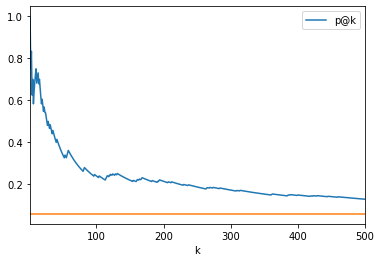

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure()
df[["k", "p@k"]][:500].plot(x="k", y= "p@k")
plt.plot(df[["k"]].values, np.full((len(df[["k"]]),1), 0.06))

In [14]:
twitter_config._name = "twitter_" + "LogisticRegression_" # + str(i) + "_"
IsoForest_learner = SkLearner(labels=labels).set_logistic_regression_classifier()
glc = GraphLearningController(IsoForest_learner, twitter_config)
result_path = os.path.join(output_folder, twitter_config.name  + "res.csv")
glc.evaluate_classifier(twitter_graph, 
                        test_size={"neg": 2000, "pos": 200},
                        training_size={"neg": 5000, "pos": 5000}, 
                        meta_data_cols=meta_data_cols)

Setting training and test sets


  7%|▋         | 157/2200 [00:00<00:01, 1566.74feature/s]

Graph loaded


70951feature [00:32, 2169.38feature/s]                    
  3%|▎         | 284/10000 [00:00<00:07, 1370.58feature/s]

Features were written to: /Users/anishsah/Documents/CS221/Network-Anomaly-Detection/data/temp/twitter_LogisticRegression__test.csv
Graph loaded


100%|██████████| 10000/10000 [00:04<00:00, 2003.41feature/s]


Features were written to: /Users/anishsah/Documents/CS221/Network-Anomaly-Detection/data/temp/twitter_LogisticRegression__train.csv


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Fram

Training 10-fold validation: {'auc': 0.8808958, 'recall': 0.3258, 'precision': 0.5199008889888408, 'accuracy': 0.618, 'fpr': 0.08980000000000002, 'tnr': 0.9102}
An error occuurred.


In [15]:
twitter_config._name = "twitter_" + "RandomForest_" # + str(i) + "_"
IsoForest_learner = SkLearner(labels=labels).set_randomforest_classifier()
glc = GraphLearningController(IsoForest_learner, twitter_config)
result_path = os.path.join(output_folder, twitter_config.name  + "res.csv")
glc.evaluate_classifier(twitter_graph, 
                        test_size={"neg": 2000, "pos": 200},
                        training_size={"neg": 5000, "pos": 5000}, 
                        meta_data_cols=meta_data_cols)

Setting training and test sets


  7%|▋         | 151/2200 [00:00<00:01, 1508.69feature/s]

Graph loaded


71449feature [00:30, 2369.37feature/s]                    
  2%|▏         | 177/10000 [00:00<00:05, 1762.11feature/s]

Features were written to: /Users/anishsah/Documents/CS221/Network-Anomaly-Detection/data/temp/twitter_RandomForest__test.csv
Graph loaded


100%|██████████| 10000/10000 [00:03<00:00, 2682.99feature/s]


Features were written to: /Users/anishsah/Documents/CS221/Network-Anomaly-Detection/data/temp/twitter_RandomForest__train.csv


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Fram

Training 10-fold validation: {'auc': 0.8904672, 'recall': 0.5349999999999999, 'precision': 0.7611439781089424, 'accuracy': 0.6963, 'fpr': 0.14240000000000003, 'tnr': 0.8576}
An error occuurred.


In [16]:
twitter_config._name = "twitter_" + "IsolationForest_" # + str(i) + "_"
IsoForest_learner = SkLearner(labels=labels).set_isolation_forest_classifier()
glc = GraphLearningController(IsoForest_learner, twitter_config)
result_path = os.path.join(output_folder, twitter_config.name  + "res.csv")
glc.evaluate_classifier(twitter_graph, 
                        test_size={"neg": 2000, "pos": 200},
                        training_size={"neg": 5000, "pos": 5000}, 
                        meta_data_cols=meta_data_cols)

Setting training and test sets


 20%|█▉        | 435/2200 [00:00<00:01, 1720.46feature/s]

Graph loaded


71103feature [00:26, 2702.61feature/s]                    
  2%|▏         | 170/10000 [00:00<00:05, 1696.22feature/s]

Features were written to: /Users/anishsah/Documents/CS221/Network-Anomaly-Detection/data/temp/twitter_IsolationForest__test.csv
Graph loaded


100%|██████████| 10000/10000 [00:03<00:00, 2688.14feature/s]


Features were written to: /Users/anishsah/Documents/CS221/Network-Anomaly-Detection/data/temp/twitter_IsolationForest__train.csv


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework

Training 10-fold validation: {'auc': 0.8886723999999999, 'recall': 0.47620000000000007, 'precision': 0.643486135294892, 'accuracy': 0.6723, 'fpr': 0.1316, 'tnr': 0.8684000000000001}
An error occuurred.
